# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt_tab')

from collections import Counter
from typing import List, Tuple
import string
import random
import os

import seaborn
seaborn.set(palette='summer')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
def fixedseed (seed: int=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [6]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [8]:
dataset['train'][0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

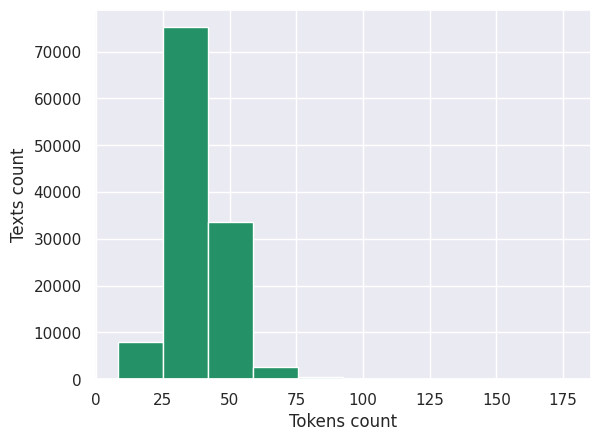

In [9]:
tokens_length = list(map(lambda i:len(i.split()), dataset['train']['text']))
plt.hist(tokens_length)
plt.xlabel('Tokens count')
plt.ylabel('Texts count')
plt.show()

Видим, что длина большинства текстов не превышает 75, большинство текстов содержат 25-50 токенов.

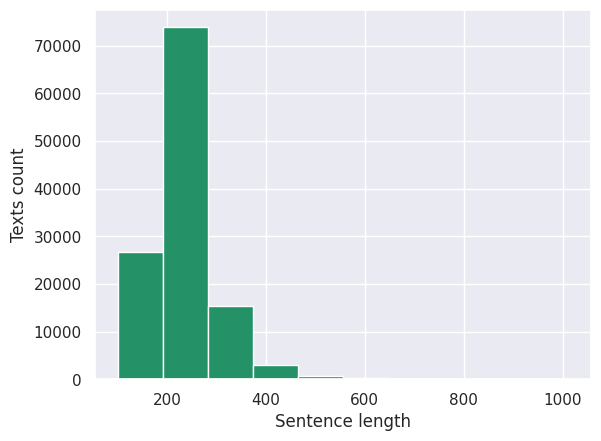

In [10]:
tokens_length = list(map(lambda i:len(i), dataset['train']['text']))
plt.hist(tokens_length)
plt.xlabel('Sentence length')
plt.ylabel('Texts count')
plt.show()

Видим, что длина большинства текстов не превышает 400 символов.

In [11]:
from collections import Counter

In [12]:
c = Counter(list(dataset['train']['label']))
print(c)

Counter({2: 30000, 3: 30000, 1: 30000, 0: 30000})


**Выборка полностью сбалансирована по всем классам.**



---


Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [13]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # к нижнему регистру + убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [14]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:# задаем макс длину текстов в датасете
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len) # длина предложений <= 256

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id) # заполнение pad_id до max_seq_len

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device) # преобразуем списки с seq and labels в одномерные тензоры
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [15]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [16]:
train_dataset[1]

{'text': [480,
  1642,
  1283,
  5339,
  11460,
  1176,
  2123,
  2123,
  8929,
  2280,
  1637,
  1642,
  1642,
  2889,
  1940,
  2628,
  3865,
  9732,
  1642,
  9754,
  1642,
  1571,
  4783,
  153,
  2569,
  4409,
  2889,
  1418,
  1642,
  587,
  8475,
  10210,
  11098,
  2441,
  153,
  5066,
  2599],
 'label': 2}

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [17]:
def evaluate(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy


### Вспомогательные функции: функция для обучения модели



In [18]:
def training(model, train_dataloader, eval_dataloader, num_epoch:int = 7):
  eval_steps = len(train_dataloader) // 2

  losses = []
  acc = []

  fixedseed()
  model = model
  fixedseed()
  criterion = nn.CrossEntropyLoss()
  fixedseed()
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(num_epoch):
    epoch_losses = []
    model.train()

    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
      optimizer.zero_grad()
      logits = model(batch['input_ids'])
      loss = criterion(logits, batch['label'])
      loss.backward()
      optimizer.step()

      epoch_losses.append(loss.item())
      if i % eval_steps == 0:
        model.eval()
        acc.append(evaluate(model))
        model.train()
    losses.append(sum(epoch_losses) / len(epoch_losses))

  return losses, acc


### Вспомогательные функции: функция для отрисовки графиков прогресса обучения


In [19]:
losses_type = {}
acc_type = {}

In [20]:
def plotting(losses: Tuple, acc: Tuple):
  plt.figure(figsize=(10,2))
  for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)
  plt.title('Losses')
  plt.xlabel("epoch")
  plt.legend()
  plt.show()
  plt.figure(figsize=(10,2))
  for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Best result for {name}: {(max(acc_type[name]) * 100):.2f}")

  plt.title('Accuracy')
  plt.xlabel("epoch")
  plt.legend()
  plt.show()

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

##**1. Baseline RNN model**

In [24]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ): # размер скрытого слоя, размер словаря, количество классов предсказания и тип аггрегирования
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim) # матрица эмбеддингов: [к-во слов в словаре * размер скрытого слоя]
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True) # RNN layer
        self.linear = nn.Linear(hidden_dim, hidden_dim) # Linear layer
        self.projection = nn.Linear(hidden_dim, num_classes) # Linear layer dim * num classes
        self.non_lin = nn.Tanh() # гиперболический тангенс
        self.dropout = nn.Dropout(p=0.15)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max': # maxpooling-агрегация по первой размерности (seq_len)
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean': # averagepooling-агрегация по первой размерности (seq_len)
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [26]:
for aggregation_type in ['max', 'mean']:
    fixedseed()
    print(f'Starting for {aggregation_type}')
    model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    losses_type[aggregation_type], acc_type[aggregation_type] = training(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=5) # 5 эпох для экономи времени

Starting for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

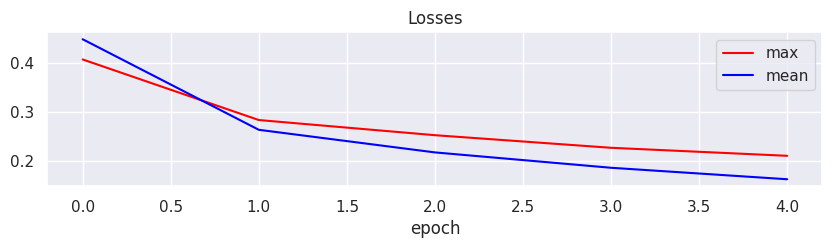

Best result for max: 90.12
Best result for mean: 90.64


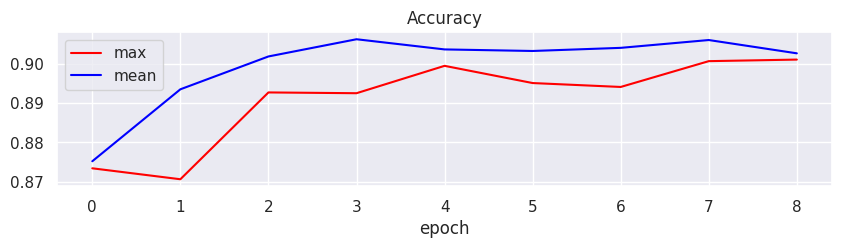

In [27]:
plotting(losses_type, acc_type)

##**2. Эксперименты по улучшению модели**

### **2.1. GRU model**

In [25]:
class CharLM_GRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True) # GRU layer
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.05)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))

        return prediction

In [26]:
losses_type = {}
acc_type = {}
for aggregation_type in ['max', 'mean']:
    fixedseed()
    print(f'Starting for {aggregation_type}')
    model = CharLM_GRU(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    losses_type[aggregation_type], acc_type[aggregation_type] = training(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=5)

Starting for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

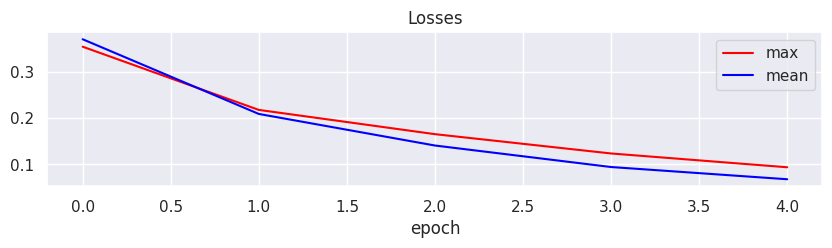

Best result for max: 91.34
Best result for mean: 91.16


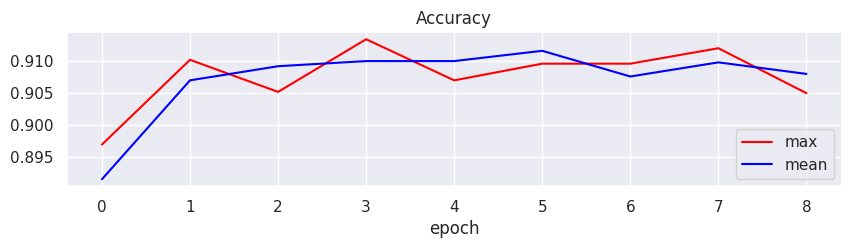

In [30]:
plotting(losses_type, acc_type)

### **2.2, 2.3. Increasing the number of RNN layers + bidirectional RNN**

In [21]:
class CharLM_bidirectional_2layers(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', num_layers: int = 2, bidirectional: bool = True
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(
            hidden_dim, hidden_dim, batch_first=True,
            num_layers=num_layers, bidirectional=bidirectional
        )
        self.linear = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim * num_directions]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))

        return prediction

In [22]:
losses_type = {}
acc_type = {}
for aggregation_type in ['max', 'mean']:
    fixedseed()
    print(f'Starting for {aggregation_type}')
    model = CharLM_bidirectional_2layers(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    losses_type[aggregation_type], acc_type[aggregation_type] = training(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=5)

Starting for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

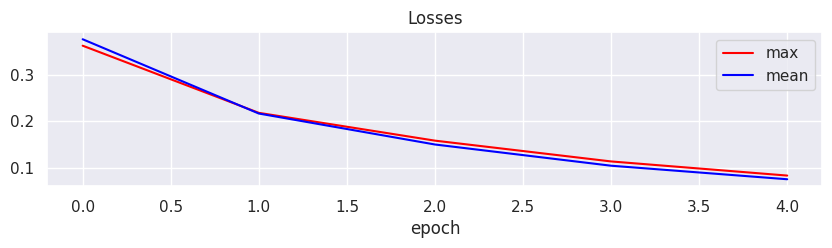

Best result for max: 91.62
Best result for mean: 91.52


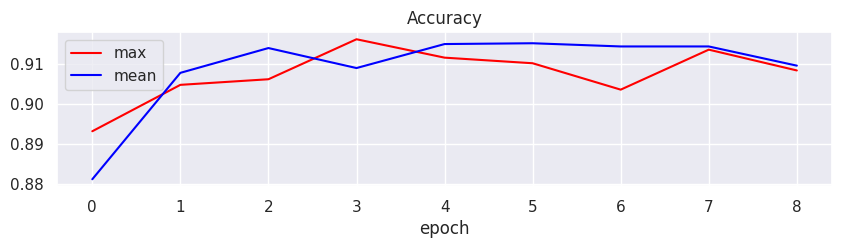

In [43]:
plotting(losses_type, acc_type)

### **2.4. LSTM**

In [37]:
class LSTM_bidirectional_2layers(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', num_layers: int = 2, bidirectional: bool = False
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(
            hidden_dim, hidden_dim, batch_first=True,
            num_layers=num_layers, bidirectional=bidirectional
        )
        self.linear = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.05)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim * num_directions]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))

        return prediction

In [38]:
losses_type = {}
acc_type = {}
for aggregation_type in ['max', 'mean']:
    fixedseed()
    print(f'Starting for {aggregation_type}')
    model = LSTM_bidirectional_2layers(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    losses_type[aggregation_type], acc_type[aggregation_type] = training(model=model, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=5)

Starting for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

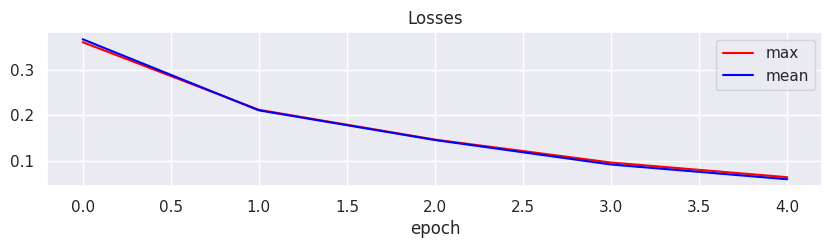

Best result for max: 91.96
Best result for mean: 91.68


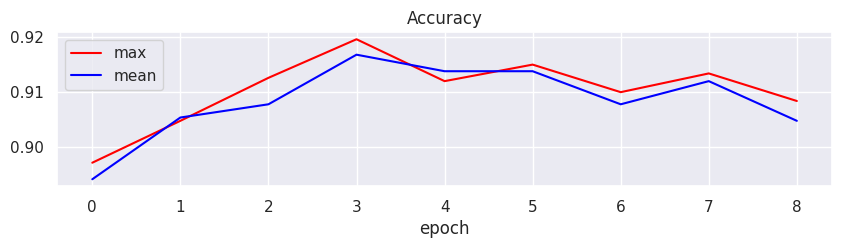

In [39]:
plotting(losses_type, acc_type)

In [42]:
model

LSTM_bidirectional_2layers(
  (embedding): Embedding(11842, 256)
  (rnn): LSTM(256, 256, num_layers=2, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.05, inplace=False)
)

## **Отчет**

1. **Accuracy для Baseline RNN model с одним реккурентным слоем**:
* best result for max per 5 epochs: 90.12
* best result for mean per 5 epochs: 90.64

Были проведены несколько экспериментов в параграфе 2:

2. **Изменение vanilla RNN -> GRU в комбинации с более "нежным" dropout=0.05, сразу дало ощутимый прирост и позволило достичь метрики Accuracy**
* best result for max per 5 epochs: 91.34
* best result for mean per 5 epochs: 90.16

3. **Добавление к GRU доп. реккурентного слоя и двунаправленности, вкупе с более агрессивным dropout=0.2 (чтобы модель не переобучалась), дало еще больший прирост метрики** (что, вроде бы понятно, так как решаемая задача - задача классификации: двунаправленность модели позволяет лучше учитывать контекст)
* best result for max per 5 epochs: 91.62
* best result for mean per 5 epochs: 91.52

4. **Лидером (ожидаемо) LSTM с двумя слоями, вкупе с dropout=0.05** (что, вроде бы понятно, так как решаемая задача - задача классификации: двунаправленность модели позволяет лучше учитывать контекст)
* best result for max per 5 epochs: 91.96
* best result for mean per 5 epochs: 91.68

---


**ИТОГИ**

1. Лучшая модель - LSTM с модификаицями (доп. кол-во рек. слоев - 2 слоя), при этом даже базовая GRU дала очень неплохое значение метрики. Отмечу, что при увеличении  эпох, значения метрик возрастают, однако возрастает и время обучения. Интересно, что при уменьшении  dropout метрика при max-агрегации падает, а для mean-агрегации растет

2. По графикам сходимости можно увидеть, что в начале метрика агрегации типа "max" ведет себя менее стабильно, чем "mean", однако на более поздних эпохах динамика уменьшается, и метрики для разных типов агрегации сближаются. Также можно заметить, что к 5й эпохе метрика имеет тенденцию к снижению acc. Скорее всего, для лучшей сходимости стоит увеличить количество эпох.
